# COGS 108 - EDA Checkpoint

# Names

- Brandon Vazquez
- Ernesto Escusa
- Chung En Pan
- Manuel Rodriguez Nunez
- Eric Estabaya

<a id='research_question'></a>
# Research Question

How has the COVID-19 infection rate influenced the video game community?

# Setup

In [1]:
#pip install seaborn

In [92]:
import os
import glob
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')


# Data Cleaning

<strong>Step 1: </strong>
<br>Since Playercounthistory1 and Playercounthistory2 contains the games player count at a 5 minutes/ 1 hour increment, we would want to normalize the data to match the the COVID- 19 data. Here we turned the 'date' variable to proper date time object, and groupby the mean of the player count for each day. Then saved into the csv files.

In [3]:
def wrangle_datetime(folder):

    empty_file= np.array([])
    filepath = '~/Github/covid_game_analysis/data/steaminfo/'+ folder
    
    for filename in os.listdir(filepath):
        filename_path = filepath + '/' + filename
        if filename.endswith('.csv'):
            if os.stat(filename_path).st_size !=0:
                with open(os.path.join(filepath, filename),'r+') as f:
                    print(filename)
                    temp= pd.read_csv(f,dtype={"Time": str, "PlayerCount": float})
                    temp['Time']= pd.to_datetime(temp['Time'], errors='coerce', format='%Y-%m-%d %H:%M')
                    temp = temp.dropna(axis=0)
                    result= temp.groupby([temp['Time'].dt.date]).mean()
                    result['Playercount']= result['Playercount'].apply(int)
                    result.to_csv(path_or_buf= filename_path)
                
        else:
            empty_file= np.append(empty_file,filename)
    print('empty_file', empty_file)
#wrangle_datetime('PlayerCountHistoryPart1')
#wrangle_datetime('PlayerCountHistoryPart2')

**Step 2:**
Since the player count history are organized based on each game_id, it would the the best if we can merge the player count history with each game id in a single table. Below are the function to procduce a single table

In [4]:
def mergeinfo():
    temp_info = pd.read_csv('data/steaminfo/Information.csv', encoding='unicode_escape')
    df = pd.DataFrame()
    empty_file= np.array([])
    for id in temp_info.get('appid'):
        
        file_path = 'data/steaminfo/PlayerCountHistory/' + str(id) + '.csv' 
        if os.stat(file_path).st_size !=0:
            with open(file_path, 'r') as f:
                f_csv = pd.read_csv(f,dtype={"Time": str, "Playercount": float})
                f_csv['appid'] = id
                temp = pd.DataFrame()
                temp = temp.append(temp_info[temp_info.get('appid') == id])
                temp = temp.merge(f_csv, how = 'inner', on = 'appid')
                df = df.append(temp)
                
        else:
            empty_file= np.append(empty_file,id)
    print('empty_file:',empty_file)
    df['Time']= pd.to_datetime(df['Time'], errors='coerce', format='%Y-%m-%d')
    return df
df = mergeinfo() 

empty_file: [397100.]


Here we see that game_id 397100 is empty, so we will omit this observation (game).

In [5]:
df.head()


,appid,type,name,releasedate,freetoplay,Time,Playercount
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,2017-12-14,1248227.0
1,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,2017-12-15,1427167.0
2,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,2017-12-16,1540028.0
3,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,2017-12-17,1451095.0
4,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,2017-12-18,1231938.0


**Step3:** Now we have merge the playercount based on each day with the corresponding game id, containing 1938929 rows × 7 columns. We can now shift our focus to adding the price correspond to each date.
Note: the data from 'PriceHistory' are recorded since 2019-04-07, so we will append the price along with dicounts to the merged dataframe and eventually drop the data that are before recorded date.

First, let's take a look one instance of the pricehistory.

In [6]:
pricehistory1 = pd.read_csv('data/steaminfo/PriceHistory/10.csv')
display(pricehistory1.head())
pricehistory1.dtypes

,Date,Initialprice,Finalprice,Discount
0,2019-04-07,9.99,9.99,0
1,2019-04-08,9.99,9.99,0
2,2019-04-09,9.99,9.99,0
3,2019-04-10,9.99,9.99,0
4,2019-04-11,9.99,9.99,0


Date             object
Initialprice    float64
Finalprice      float64
Discount          int64
dtype: object

As we can tell that the 'date' variable type is an object, so for easier wrangling purposes and merging purposes, we shall turn the 'date' variable type to datetime object. Then we will merge the price information into the merged dataframe based on game id and the date.

Note: The price history are only recorded from 2019-04-07 through 2020-08-12.

In [7]:
def merge_price(dataframe):
    temp = pd.DataFrame()
    empty_file = np.array([])
    for game_id in dataframe.get('appid').unique():
        file_path = 'data/steaminfo/PriceHistory/' + str(game_id) + '.csv'
        if os.path.exists(file_path): 
            if os.stat(file_path).st_size !=0:
                with open(file_path,'r') as f:
                    f_csv = pd.read_csv(f,dtype={"Date": str, "Initialprice": float, "Finalprice": float, 'Discount': float})
                    f_csv = f_csv.rename(columns= {'Date':'Time'})
                    f_csv['Time']= pd.to_datetime(f_csv['Time'], errors='coerce', format='%Y-%m-%d')
                    f_csv['appid'] = game_id
                    temp = temp.append(f_csv)   
            else:
                empty_file= np.append(empty_file,str(game_id))
        else:
            empty_file = np.append(empty_file,str(game_id))
    dataframe = dataframe.merge(temp, how = 'outer', on = ['appid','Time'])
    print('empty_file:',empty_file)
    return dataframe

In [8]:
new_df = merge_price(df)

empty_file: ['570' '730' '622590' '238960' '230410' '440' '433850' '444090' '482730'
 '304930' '504370' '236390' '363970' '601510' '386360' '444200' '480'
 '550650' '291550' '378120' '227940' '698780' '259360' '291480' '386180'
 '304050' '627690' '453480' '8500' '301520' '552990' '466240' '295270'
 '109600' '738060' '592580' '555570' '268850' '610080' '333930' '438040'
 '588430' '346900' '323370' '218230' '513650' '211420' '200210' '212740'
 '273110' '473500' '42690' '295110' '231670' '380600' '536930' '280790'
 '9900' '316010' '389430' '506540' '216150' '506140' '402840' '364470'
 '663090' '372000' '456610' '397900' '444640' '335240' '329110' '253710'
 '612020' '286940' '342200' '339600' '339610' '212500' '531640' '1840'
 '113400' '236870' '438100' '442080' '261430' '550900' '459820' '71270'
 '319630' '288390' '22490' '304030' '47410' '592600' '24200' '236110'
 '207890' '365670' '564710' '581690' '217490' '557400' '537180' '215080'
 '504730' '42750' '302830' '204300' '224260' '706220'

There are a lot of empty files from the price history. Which suggests that some of the games price information are missing. Therefore these observations (games) will be omited when analysis involves price history.

In [9]:
new_df

,appid,type,name,releasedate,freetoplay,Time,Playercount,Initialprice,Finalprice,Discount
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,2017-12-14,1248227.0,NaN,NaN,NaN
1,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,2017-12-15,1427167.0,NaN,NaN,NaN
2,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,2017-12-16,1540028.0,NaN,NaN,NaN
3,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,2017-12-17,1451095.0,NaN,NaN,NaN
4,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,2017-12-18,1231938.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1938924,304730,game,Train Fever,4-Sep-14,0.0,2020-08-08,28.0,19.99,19.99,0.0
1938925,304730,game,Train Fever,4-Sep-14,0.0,2020-08-09,29.0,19.99,19.99,0.0
1938926,304730,game,Train Fever,4-Sep-14,0.0,2020-08-10,24.0,19.99,19.99,0.0
1938927,304730,game,Train Fever,4-Sep-14,0.0,2020-08-11,24.0,19.99,19.99,0.0


In [10]:
covid = pd.read_csv('data/owid-covid-data.csv')
info = pd.read_csv('data/steaminfo/Information.csv', encoding='unicode_escape')
tags = pd.read_csv('data/steaminfo/Tags.csv', encoding='unicode_escape',error_bad_lines=False)
developers = pd.read_csv('data/steaminfo/Developers.csv', encoding='unicode_escape',error_bad_lines=False)
info

,appid,type,name,releasedate,freetoplay
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0
1,570,game,Dota 2,9-Jul-13,1.0
2,730,game,Counter-Strike: Global Offensive,21-Aug-12,1.0
3,622590,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS (Test Server),NaN,NaN
4,359550,game,Tom Clancy's Rainbow Six Siege,1-Dec-15,0.0
...,...,...,...,...,...
1995,34000,advertising,Football Manager 2010,29-Oct-09,1.0
1996,202480,NaN,Skyrim Creation Kit,NaN,NaN
1997,429050,game,Feed and Grow: Fish,8-Jan-16,0.0
1998,209650,game,Call of Duty: Advanced Warfare,3-Nov-14,0.0


# Data Analysis & Results (EDA)

While we are analyzing video game data, we are more concerned with the actual games, instead of looking at downloadable extended content, advertisements, and the like.

In [11]:
#sns.countplot(data=new_df, y='Playercount')
#new_df['type'].unique()
game_df = new_df[new_df['type'] == 'game']

In this analysis, we will only look at top 100 games in steam community.

In [127]:
top_df = game_df.groupby('name').mean().sort_values('Playercount', ascending = False)
top_df = top_df.head(100)
top_df.head()

,appid,freetoplay,Playercount,Initialprice,Finalprice,Discount
name,,,,,,
PLAYERUNKNOWN'S BATTLEGROUNDS,578080.0,0.0,538642.069887,29.990000,27.555923,8.113590
Dota 2,570.0,1.0,462112.040082,NaN,NaN,NaN
Counter-Strike: Global Offensive,730.0,1.0,429399.503597,NaN,NaN,NaN
Tom Clancy's Rainbow Six Siege,359550.0,0.0,74642.961973,20.030568,17.082901,14.602434
Grand Theft Auto V,271590.0,0.0,74578.025694,29.990000,25.882495,13.691684


Playercount among those top 100 games 

count       100.000000
mean      26119.818060
std       81156.919603
min        2691.229188
25%        3995.698099
50%        8003.358684
75%       14975.329137
max      538642.069887
Name: Playercount, dtype: float64

count       97.000000
mean     12183.795798
std      13623.164940
min       2691.229188
25%       3993.676259
50%       7819.958890
75%      14296.398767
max      74642.961973
Name: Playercount, dtype: float64

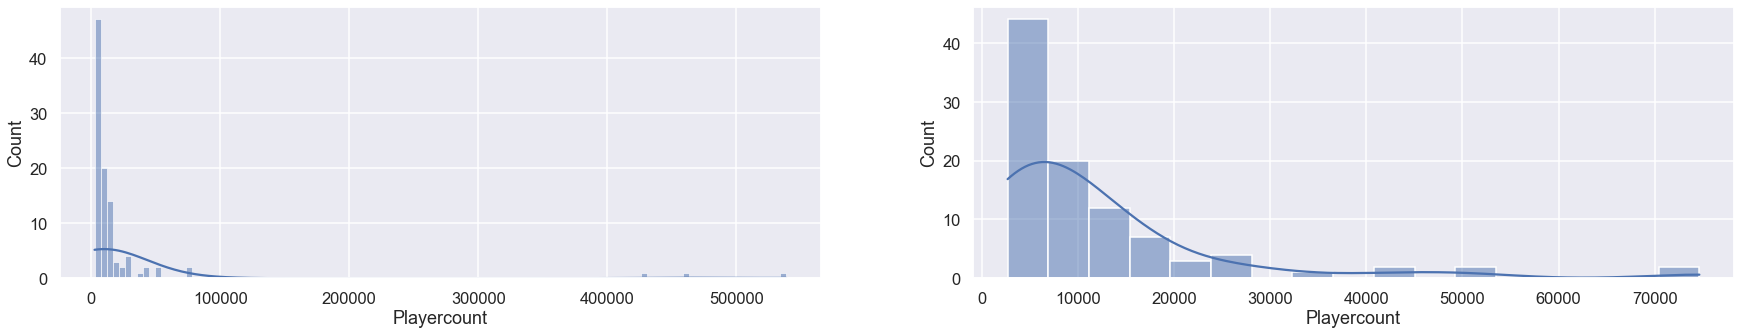

In [91]:
fig, axes = plt.subplots(1,2, figsize =( 30, 5))
temp = top_df.get('Playercount')
sns.histplot(temp, kde = True, ax = axes[0])
display(temp.describe())
temp = top_df.tail(97).get('Playercount')
sns.histplot(temp, kde = True, ax = axes[1])
display(temp.describe())

From the histogram above we can also tell there are few outliers that are way more than the rest of the game. We can filter and see what are the games being outliers and when those outliers are taken away, what is the histogram look like.

Now, let us inspect the  discount rate over time

<AxesSubplot:xlabel='Time', ylabel='Discount'>

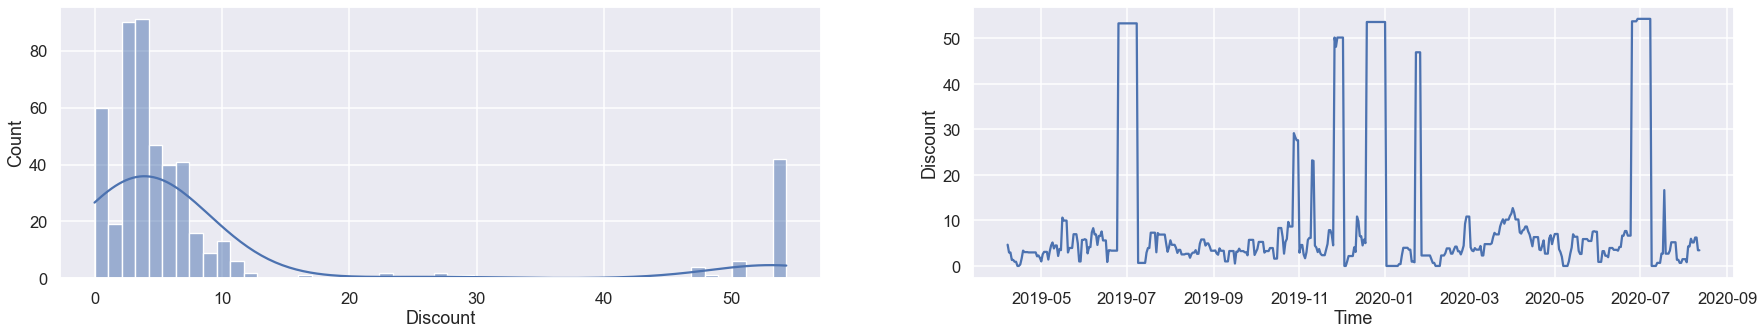

In [140]:
fig, axes = plt.subplots(1,2, figsize =( 30, 5))
top_name = game_df.groupby('name').mean().sort_values('Playercount', ascending = False).index[0:100]
discount = game_df[game_df['name'].isin(top_name)]
discount = discount.get(['Time','Discount']).groupby('Time').mean()
sns.histplot(data = discount.get('Discount'), kde = True, ax = axes[0])
sns.lineplot(data = discount, x = discount.index, y = discount.get('Discount'))

We want to look at the player count across all games, but to get a more accurate representation of our data, its best to look at the average player count per day.

In [94]:
#len(game_df['releasedate'].unique())
count_by_time = game_df.groupby('Time')['Playercount'].apply(np.array).reset_index()
count_by_time['avg'] = count_by_time['Playercount'].map(lambda li: li)

count_by_time['Playercount'] = count_by_time['Playercount'].apply(lambda li: sum(li))
count_by_time['avg'] = count_by_time['avg'].apply(lambda li: sum(li)/len(li))

#count_by_time.drop(['Time'], axis=1)
count_by_time = count_by_time[['Time', 'Playercount', 'avg']]

count_by_time.head()

,Time,Playercount,avg
0,2017-12-14,3325622.0,1894.941311
1,2017-12-15,3785958.0,2157.241026
2,2017-12-16,4406876.0,2511.040456
3,2017-12-17,4362308.0,2485.645584
4,2017-12-18,3607412.0,1949.952432


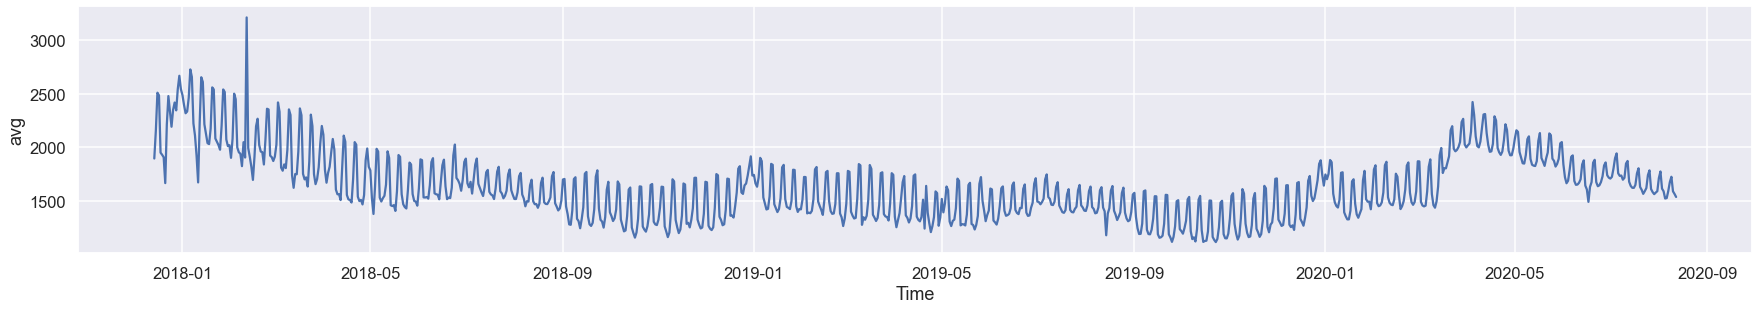

In [154]:
#count_by_year['Playercount'].hist()
fig, axes = plt.subplots(2,1, figsize = (30,10))
sns.lineplot(data=count_by_time, x='Time', y='avg', ax = axes[0])
axes[1].remove()

This graph looks a little messy if we decide to analyze player count across each individual day starting from the end of 2017. Rather than looking at daily averages, we can observe monthly averages.

In [96]:
def transform_time(time_str):
    parts = time_str.split('-')
    return (parts[0] + '-' + parts[1])

In [97]:
count_by_month = count_by_time.copy()
count_by_month['Time'] = count_by_month['Time'].astype(str).apply(transform_time)

count_by_month = count_by_month.groupby('Time')['avg'].apply(np.array).reset_index()

count_by_month['avg'] = count_by_month['avg'].apply(lambda li: sum(li)/len(li))

count_by_month.head()

,Time,avg
0,2017-12,2255.328784
1,2018-01,2258.009939
2,2018-02,2066.851691
3,2018-03,1947.247227
4,2018-04,1747.834523


Graph of average playercount


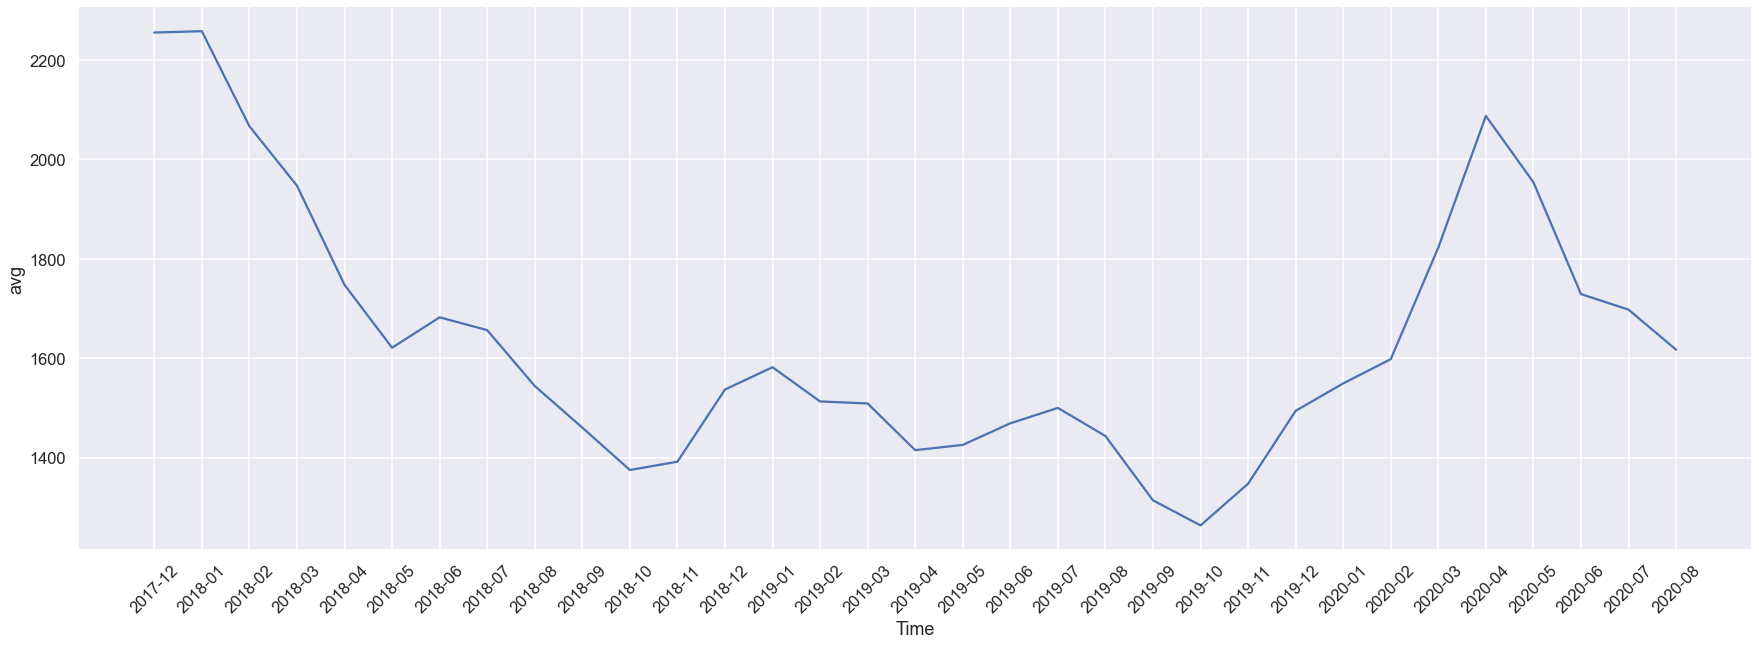

In [177]:
fig, ax = plt.subplots(figsize =(30,10))
graph = sns.lineplot(data=count_by_month, x='Time', y='avg')
plt.setp(graph.get_xticklabels(), rotation=45)
print('Graph of average playercount')

The graph looks a little better, but now the x-axis is a bit messy.

Note: The x-axis will be fixed later on

We will now start breaking down our data on COVID-19 cases across 2020 and into January 2021.

In [99]:
covid

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62822,ZWE,Africa,Zimbabwe,2021-01-24,31320.0,313.0,588.143,1005.0,31.0,41.714,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.535
62823,ZWE,Africa,Zimbabwe,2021-01-25,31646.0,326.0,536.286,1075.0,70.0,43.143,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.535
62824,ZWE,Africa,Zimbabwe,2021-01-26,32004.0,358.0,475.571,1103.0,28.0,39.714,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.535
62825,ZWE,Africa,Zimbabwe,2021-01-27,32304.0,300.0,413.714,1122.0,19.0,34.714,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.535


Rather than observing each individual country, we will sort the number of cases by a daily total.

In [106]:
covid_test = covid.copy()

covid_by_time = covid_test.groupby('date')['total_cases'].apply(np.array).reset_index()
covid_by_time

,date,total_cases
0,2020-01-01,"[nan, nan]"
1,2020-01-02,"[nan, nan]"
2,2020-01-03,"[nan, nan]"
3,2020-01-04,"[nan, nan, nan]"
4,2020-01-05,"[nan, nan, nan]"
...,...,...
390,2021-01-25,"[54672.0, 72812.0, 105854.0, 9596.0, 19476.0, ..."
391,2021-01-26,"[54750.0, 73691.0, 106097.0, 9638.0, 19553.0, ..."
392,2021-01-27,"[54854.0, 74567.0, 106359.0, 9716.0, 19580.0, ..."
393,2021-01-28,"[54891.0, 75454.0, 106610.0, 9779.0, 19672.0, ..."


With a little bit of work, we can simplify our COVID-19 infection count per day and observe the rate of COVID-19 infections on a monthly basis.

In [107]:
def format_cases(li):
    if np.nan in li or "nan" in li:
        return np.nan

    return sum(li)

In [108]:
covid_by_time['total_cases'] = covid_by_time['total_cases'].apply(format_cases)

covid_by_time = covid_by_time.dropna()

covid_by_time['date'] = covid_by_time['date'].astype(str).apply(transform_time)
covid_by_time = covid_by_time.groupby('date')['total_cases'].apply(np.array).reset_index()

covid_by_time['total_cases'] = covid_by_time['total_cases'].apply(format_cases)

covid_by_time

<ipython-input-107-2be4cd70192b>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.nan in li or "nan" in li:
<ipython-input-108-bc4e4897b262>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_by_time['date'] = covid_by_time['date'].astype(str).apply(transform_time)
<ipython-input-107-2be4cd70192b>:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.nan in li or "nan" in li:


,date,total_cases
0,2020-03,5.462726e+06
1,2020-04,1.186691e+08
2,2020-05,2.780458e+08
3,2020-06,4.724016e+08
4,2020-07,8.283304e+08
5,2020-08,1.292298e+09
6,2020-11,3.172407e+09
7,2020-12,4.423400e+09
8,2021-01,1.583081e+09


<AxesSubplot:xlabel='date', ylabel='total_cases'>

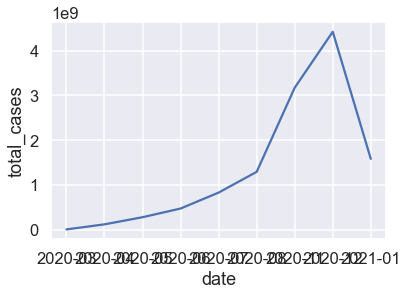

In [45]:
sns.lineplot(data=covid_by_time, x='date', y='total_cases')

NOTE: axes will need to be formatted